# 基于本地大语言模型（LLM）的纠正性检索增强生成（CRAG）

[纠正性检索增强生成（Corrective-RAG，简称CRAG）](https://arxiv.org/abs/2401.15884)是一种检索增强生成（RAG）策略，该策略会对检索到的文档进行自我反思与自我评分。

该论文遵循以下通用流程：
* 若至少有一份文档的**相关性**超过阈值，则进入生成阶段
* 若所有文档的**相关性**均低于阈值，或评分器无法确定相关性，则通过网络搜索补充检索内容
* 在生成内容前，会对搜索到的文档或检索到的文档进行知识优化
* 将文档划分为多个**知识片段（knowledge strips）**
* 对每个知识片段进行评分，并过滤掉不相关的片段


我们将基于[LangGraph](https://langchain-ai.github.io/langgraph/)从零开始实现其中部分思路：
* 若存在**任何**不相关的文档，我们将通过网络搜索补充检索内容
* 暂不执行知识优化步骤，但如有需要，可将其作为一个节点重新加入流程
* 网络搜索将使用[Tavily Search](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/)工具

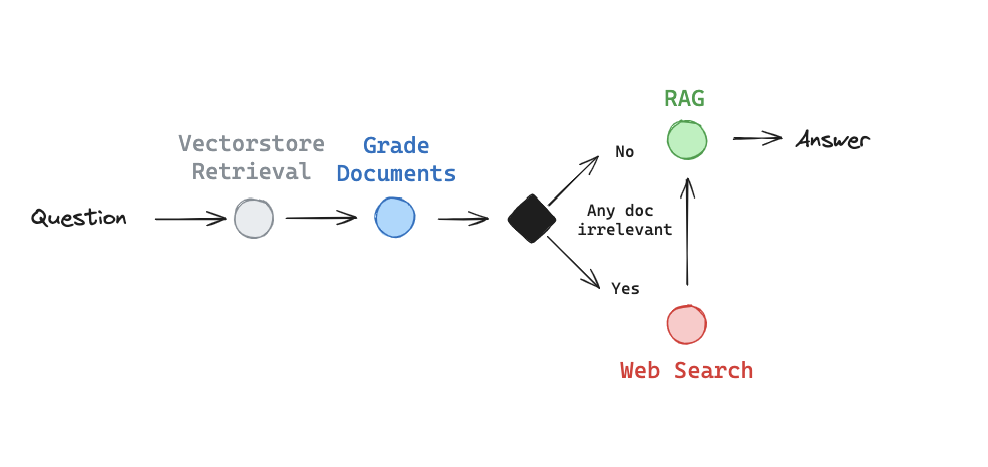


### 术语说明（补充）
- **RAG（Retrieval-Augmented Generation）**：检索增强生成，是一种结合外部知识库检索与大语言模型生成能力的技术，可提升生成内容的准确性与时效性。
- **LLM（Large Language Model）**：大语言模型，指参数规模庞大、具备强大自然语言理解与生成能力的人工智能模型（如GPT系列、Llama系列等）。
- **LangGraph**：LangChain生态下的图结构工作流工具，可用于构建具备循环、分支逻辑的复杂AI应用流程，适用于CRAG这类多步骤决策场景。

## 配置说明

我们将使用 [Ollama](https://ollama.ai/) 访问本地大语言模型（LLM）：

* 下载 [Ollama 应用](https://ollama.ai/)。
* 拉取你选择的模型（示例如下）：`ollama pull llama3`

我们将使用 [Tavily](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) 进行网络搜索。

我们将使用向量数据库（vectorstore），搭配 [Nomic 本地嵌入模型](https://blog.nomic.ai/posts/nomic-embed-text-v1)；也可根据需要选择 OpenAI 嵌入模型。


接下来安装所需依赖包并配置 API 密钥：

### 翻译说明（遵循技术文档翻译规范）：
1. 术语准确性：
   - "Setup" 译为「配置说明」（技术场景中更贴合操作指引含义，而非直译「设置」）
   - "LLM" 保留缩写并补充中文全称「大语言模型」（首次出现标注）
   - "vectorstore" 译为「向量数据库」（AI 领域标准译法）
   - "embeddings" 译为「嵌入模型」（避免直译「嵌入」，明确技术属性）
   - "pull" 译为「拉取」（容器/模型操作的标准术语）
   - "API keys" 译为「API 密钥」（信息技术领域通用译法）

2. 语法适配：
   - 保持技术文档简洁性，将英文被动语态转为中文主动句式（如 "We'll use" 译为「我们将使用」）
   - 命令式操作明确化（"Download" →「下载」，"Let's install" →「接下来安装」）
   - 补充逻辑连接词（「搭配」「也可根据需要选择」），使中文更流畅

3. 细节处理：
   - 保留工具名称原文（Ollama/Tavily/Nomic/OpenAI），符合技术文档惯例
   - 模型名称 "llama3" 保留原文（专有模型名不翻译）
   - 括号补充说明位置调整（将英文后置示例移至中文「示例如下」后，更符合中文阅读习惯）
   - 链接保留原样，确保可访问性

In [ ]:
%%capture --no-stderr
%pip install langchain_community tiktoken langchainhub scikit-learn langchain langgraph tavily-python  nomic[local] langchain-nomic langchain_openai

In [5]:
import os
from dotenv import load_dotenv

# 加载 .env 文件中的环境变量
load_dotenv()

# 验证必需的环境变量是否已设置
required_env_vars = ["DEEPSEEK_API_KEY", "COHERE_API_KEY", "TAVILY_API_KEY"]

for var in required_env_vars:
    if not os.environ.get(var):
        raise ValueError(f"环境变量 {var} 未设置，请在 .env 文件中配置")
    print(f"✓ {var} 已加载")

✓ DEEPSEEK_API_KEY 已加载
✓ COHERE_API_KEY 已加载
✓ TAVILY_API_KEY 已加载


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

### LLM

You can select from [Ollama LLMs](https://ollama.com/library).

In [6]:
local_llm = "qwen3:32b"  # 替换为你本地部署的模型名称
model_tested = "qwen3:32b"
metadata = f"CRAG, {model_tested}"

## Create Index

Let's index 3 blog posts.

In [7]:
import requests
from langchain_core.embeddings import Embeddings
from typing import List

class SiliconFlowEmbeddings(Embeddings):
    def __init__(self, model: str, api_key: str, url: str, batch_size: int = 32):
        self.model = model
        self.api_key = api_key
        self.url = url
        self.batch_size = batch_size

    def _embed_batch(self, texts: List[str]) -> List[List[float]]:
        payload = {"model": self.model, "input": texts}
        headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }
        response = requests.post(self.url, json=payload, headers=headers)
        result = response.json()
        if result.get("code") not in (None, 0):
            raise ValueError(f"Embedding request failed: {result}")
        data = result.get("data")
        if not data:
            raise ValueError(f"No embedding data returned: {result}")
        return [item["embedding"] for item in data]

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        embeddings: List[List[float]] = []
        for i in range(0, len(texts), self.batch_size):
            batch = texts[i:i + self.batch_size]
            embeddings.extend(self._embed_batch(batch))
        return embeddings

    def embed_query(self, text: str) -> List[float]:
        return self.embed_documents([text])[0]


In [ ]:
# Embedding
embedding =  SiliconFlowEmbeddings(
    model="BAAI/bge-large-zh-v1.5",
    api_key=os.environ['DEEPSEEK_API_KEY'],  # 替换为你的真实 token
    url="https://api.siliconflow.cn/v1/embeddings"
)

In [9]:
import os
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings  # local

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)



USER_AGENT environment variable not set, consider setting it to identify your requests.


In [23]:
import requests
from typing import List, Optional, Sequence
from langchain_core.embeddings import Embeddings

# 本地接口速度更快
class OpenAIStyleEmbeddings(Embeddings):
    """适配 OpenAI /v1/embeddings 风格接口的嵌入实现。"""

    def __init__(
        self,
        model: str,
        base_url: str,
        api_key: Optional[str] = None,
        timeout: float = 30.0,
    ) -> None:
        self.model = model
        self.base_url = base_url.rstrip("/")
        self.api_key = api_key
        self.timeout = timeout

    def _embed_batch(self, texts: Sequence[str]) -> List[List[float]]:
        payload = {"input": list(texts), "model": self.model}
        headers = {"Content-Type": "application/json"}
        if self.api_key:
            headers["Authorization"] = f"Bearer {self.api_key}"

        response = requests.post(
            f"{self.base_url}/v1/embeddings",
            json=payload,
            headers=headers,
            timeout=self.timeout,
        )
        response.raise_for_status()
        result = response.json()

        data = result.get("data")
        if not data:
            raise ValueError(f"Embedding service returned no data: {result}")
        return [item["embedding"] for item in data]

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        return self._embed_batch(texts)

    def embed_query(self, text: str) -> List[float]:
        return self._embed_batch([text])[0]


# 使用样例
embedding = OpenAIStyleEmbeddings(
    model="BAAI/bge-large-zh-v1.5",
    base_url="http://192.168.8.230:50009",
    api_key=None,  # 如服务需要鉴权可填写
)

In [22]:
# Add the document chunks to the "vector store"
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=embedding,
)
retriever = vectorstore.as_retriever(k=4)

In [24]:
retriever.invoke('代理记忆（Agent Memory）有哪些类型？')

[Document(metadata={'id': '4cfbe778-e74e-46cc-ac91-bf3d3327d8ca', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future step

## Define Tools

In [56]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
# from langchain_mistralai.chat_models import ChatMistralAI

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0, base_url="http://192.168.8.231:11434")


# Prompt
prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given: 
    1/ a QUESTION
    2/ A FACT provided by the student
    
    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION. 
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION. 
    1 is the highest (best) score. 0 is the lowest score you can give. 
    
    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 
    
    Avoid simply stating the correct answer at the outset.
    
    Question: {question} \n
    Fact: \n\n {documents} \n\n
    
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """,
    input_variables=["question", "documents"],
)

prompt_zh = PromptTemplate(
    template="""你是一名老师，负责为测验评分。你将获得：
    1/ 一个问题（QUESTION）
    2/ 学生提供的一个事实（FACT）
    
    你正在评估相关性回忆（RELEVANCE RECALL）：
    分数为1表示FACT中的任何陈述都与QUESTION相关。
    分数为0表示FACT中的陈述与QUESTION无关。
    1是最高分（最好），0是最低分。
    
    请逐步解释你的推理过程。确保你的推理和结论是正确的。
    
    避免在开头简单地陈述正确答案。
    
    问题: {question} \n
    事实: \n\n {documents} \n\n
    
    给出一个二进制评分“是”或“否”，以表明该文件是否与问题相关。
    以JSON格式提供二进制评分，只有一个键“score”，没有前言或解释。
    """,
    input_variables=["question", "documents"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "documents": doc_txt}))

{'score': 'yes'}


In [31]:
llm = ChatOllama(model=local_llm, format="json", temperature=0, base_url="http://192.168.8.231:11434")


template2 = PromptTemplate(template="""你是一个文档相关性评估员，负责评估检索到的文档与用户问题的相关性。\n 
        以下是检索到的文档： \n\n {context} \n\n
        以下是用户问题： {question} \n
        如果文档包含与用户问题相关的关键词或语义内容，则评为相关。\n
        请给出二元评分 'yes' 或 'no' 来表示文档是否与问题相关。""",
            input_variables=["context", "question"],
        )
retrieval_grader2 = template2 | llm | JsonOutputParser()
print(retrieval_grader2.invoke({"question": question, "context": doc_txt}))

{'answer': 'yes'}


In [42]:
### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

prompt_zh = PromptTemplate(
    template="""你是一个问答任务助手。

    使用以下文件来回答问题。
    如果你不知道答案，就说你不知道。
    使用最多三句话，并保持答案简洁：
    问题: {question}
    文件: {documents}
    答案:
    """,
    input_variables=["question", "documents"],
)

rag_chain = prompt_zh | llm | StrOutputParser()

In [34]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

C:\Users\12153\AppData\Local\Temp\ipykernel_29160\730760015.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


## Create the Graph 

在此处，我们将明确定义大部分控制流，仅使用大型语言模型（LLM）来定义评分之后的单个分支点。

In [38]:
%pip list|findstr langchain

langchain                                1.1.0
langchain-classic                        1.0.0
langchain-cohere                         0.5.0
langchain-community                      0.4.1
langchain-core                           1.1.0
langchain-deepseek                       1.0.1
langchain-nomic                          1.0.1
langchain-openai                         1.1.0
langchain-text-splitters                 1.0.0
langchainhub                             0.1.21
Note: you may need to restart the kernel to use updated packages.


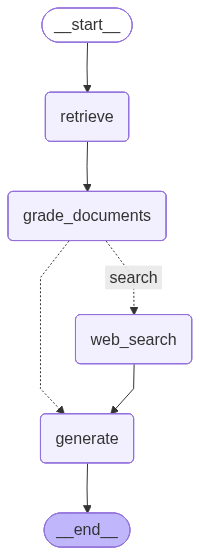

In [59]:
from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain_core.documents import Document
from langgraph.graph import START, END, StateGraph


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("Performing web search... {}".format(state["question"]))
    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [61]:
import uuid


def predict_custom_agent_local_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}

# 不走web查询分支
example = {"input": "What are the prompt engineering?"}
response = predict_custom_agent_local_answer(example)
response

{'response': '{"thought_process": "Okay, the user is asking about prompt engineering. Let me check the provided documents. The first document from Lilian Weng\'s blog defines prompt engineering as methods to communicate with LLMs to steer their behavior without updating model weights. It\'s empirical and varies between models. The other documents mention similar definitions and add that it\'s also called In-Context Prompting. There\'s a focus on autoregressive models and alignment. The answer should include the definition, mention it\'s empirical, and note the goal of alignment and steerability. I need to keep it concise, three sentences max. Let me make sure not to include any extra info not in the documents. Alright, that should cover it.", "answer": "Prompt engineering, also known as In-Context Prompting, involves methods to communicate with large language models (LLMs) to steer their behavior toward desired outcomes without modifying the model weights. It is an empirical practice w

In [62]:
example = {"input": "北京天气咋样?"}
# 走web查询分支
response = predict_custom_agent_local_answer(example)
response

Performing web search... 北京天气咋样?


{'response': '{"answer": "北京今天的天气为多云，气温在-3.8℃到4.8℃之间，风速为3.2m/s，风向为西南风，气压为1027.2hPa。未来几天的天气预报显示，12月2日为晴天，气温0℃至-8℃，风速3~4级；12月3日为晴天，气温-6℃，风速微风；12月4日为晴天，气温5℃，风速微风；12月5日为多云，气温5℃，风速微风；12月6日为晴天，气温-3℃至-8℃，风速西北风3~4级；12月7日为晴天，气温-3℃，风速微风。", "source": "https://weather.cma.cn/web/weather/"}',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

Trace: 

https://smith.langchain.com/public/88e7579e-2571-4cf6-98d2-1f9ce3359967/r

# 评估
现在我们已经定义了两种不同的智能体架构，它们的功能大致相同！

我们可以对它们进行评估。有关智能体评估的背景信息，请参阅我们的[概念指南](https://docs.smith.langchain.com/concepts/evaluation#agents)。

## 响应
首先，我们可以评估[我们的智能体在一组问答对上的表现](https://docs.smith.langchain.com/tutorials/Developers/agents#response-evaluation)。

我们将创建一个数据集，并将其保存在LangSmith中。

注：“agent architectures”在人工智能领域译为“智能体架构”，指智能体系统的结构设计；“LangSmith”是LangChain生态下的开发与评估平台，通常保留原名不翻译，均为该领域常用表述。
 

In [45]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    (
        "How does the ReAct agent use self-reflection? ",
        "ReAct integrates reasoning and acting, performing actions - such tools like Wikipedia search API - and then observing / reasoning about the tool outputs.",
    ),
    (
        "What are the types of biases that can arise with few-shot prompting?",
        "The biases that can arise with few-shot prompting include (1) Majority label bias, (2) Recency bias, and (3) Common token bias.",
    ),
    (
        "What are five types of adversarial attacks?",
        "Five types of adversarial attacks are (1) Token manipulation, (2) Gradient based attack, (3) Jailbreak prompting, (4) Human red-teaming, (5) Model red-teaming.",
    ),
    (
        "Who did the Chicago Bears draft first in the 2024 NFL draft”?",
        "The Chicago Bears drafted Caleb Williams first in the 2024 NFL draft.",
    ),
    ("Who won the 2024 NBA finals?", "The Boston Celtics on the 2024 NBA finals"),
]

# Save it
dataset_name = "Corrective RAG Agent Testing"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

Failed to get info from https://api.smith.langchain.com: LangSmithConnectionError('Connection error caused failure to GET /info in LangSmith API. Please confirm your internet connection. ConnectionError(MaxRetryError(\'HTTPSConnectionPool(host=\\\'api.smith.langchain.com\\\', port=443): Max retries exceeded with url: /info (Caused by ReadTimeoutError("HTTPSConnectionPool(host=\\\'api.smith.langchain.com\\\', port=443): Read timed out. (read timeout=10.0)"))\'))\nContent-Length: None\nAPI Key: ')


LangSmithConnectionError: Connection error caused failure to GET /datasets in LangSmith API. Please confirm your internet connection. ConnectionError(MaxRetryError('HTTPSConnectionPool(host=\'api.smith.langchain.com\', port=443): Max retries exceeded with url: /datasets?limit=1&name=Corrective+RAG+Agent+Testing (Caused by ReadTimeoutError("HTTPSConnectionPool(host=\'api.smith.langchain.com\', port=443): Read timed out. (read timeout=10.0)"))'))
Content-Length: None
API Key: 

现在，我们将使用“大型语言模型（LLM）作为评分器”，把两个智能体的响应与我们的基准参考答案进行比较。

我们可以使用的默认提示词请参见[此处](https://smith.langchain.com/hub/rlm/rag-answer-vs-reference)。

我们将采用“gpt-4o”作为我们的LLM评分器。

注：“ground truth reference answer”在AI评估领域译为“基准参考答案”，指作为评判标准的准确答案；“prompt”译为“提示词”，是引导LLM生成特定内容的输入文本；“gpt-4o”是OpenAI推出的LLM模型，通常保留原名不翻译，均为该领域常用表述。



In [ ]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")


def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get the question, the ground truth reference answer, RAG chain answer prediction
    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    # Define an LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]
    return {"key": "answer_v_reference_score", "score": score}

### Trajectory

Second, [we can assess the list of tool calls](https://docs.smith.langchain.com/tutorials/Developers/agents#trajectory) that each agent makes relative to expected trajectories.

This evaluates the specific reasoning traces taken by our agents!

In [ ]:
from langsmith.schemas import Example, Run

# Reasoning traces that we expect the agents to take
expected_trajectory_1 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "web_search",
    "generate_answer",
]
expected_trajectory_2 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "generate_answer",
]


def find_tool_calls_react(messages):
    """
    Find all tool calls in the messages returned
    """
    tool_calls = [
        tc["name"] for m in messages["messages"] for tc in getattr(m, "tool_calls", [])
    ]
    return tool_calls


def check_trajectory_react(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    messages = root_run.outputs["messages"]
    tool_calls = find_tool_calls_react(messages)
    print(f"Tool calls ReAct agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}


def check_trajectory_custom(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    tool_calls = root_run.outputs["steps"]
    print(f"Tool calls custom agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}

In [ ]:
from langsmith.evaluation import evaluate

experiment_prefix = f"custom-agent-{model_tested}"
experiment_results = evaluate(
    predict_custom_agent_local_answer,
    data=dataset_name,
    evaluators=[answer_evaluator, check_trajectory_custom],
    experiment_prefix=experiment_prefix + "-answer-and-tool-use",
    num_repetitions=3,
    max_concurrency=1,  # Use when running locally
    metadata={"version": metadata},
)

View the evaluation results for experiment: 'custom-agent-llama3-8b-answer-and-tool-use-d6006159' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/datasets/a8b9273b-ca33-4e2f-9f69-9bbc37f6f51b/compare?selectedSessions=83c60822-ef22-43e8-ac85-4488af279c6f




0it [00:00, ?it/s]

Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom a

我们可以看到，使用“自定义（Custom）”智能体（如图所示）和ReAct智能体的结果，已与“GPT-4o”和“Llama-3-70b”进行了基准对比。

 

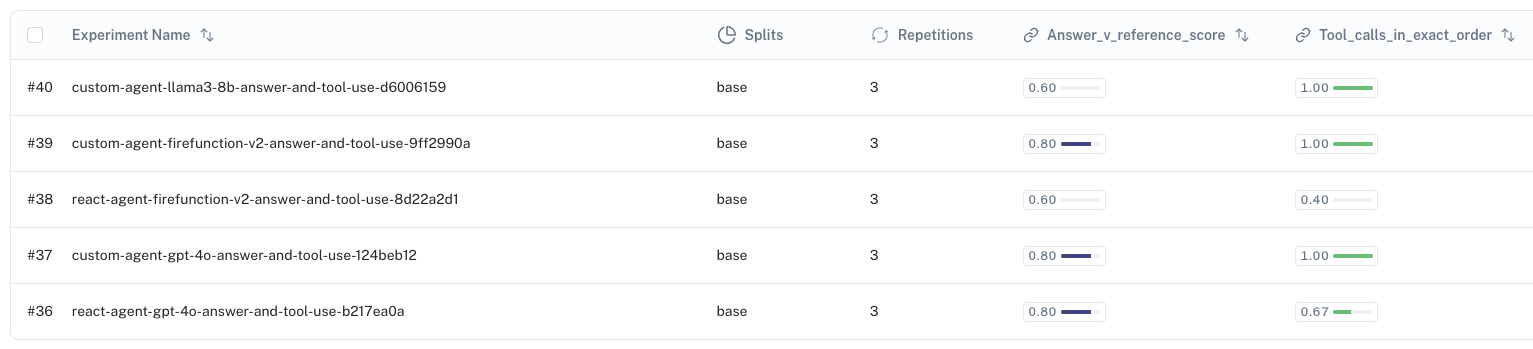

“本地自定义智能体”在工具调用可靠性方面表现良好：它能遵循预期的推理轨迹。

但在答案准确性方面，其表现落后于采用“自定义智能体”实现方案的大型模型。
 